### Prep

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
import os
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

In [2]:
train_df = pd.read_csv(r"D:\Workplace\.SPRING2025\AIL303m\Bee_Swarming\mfcc_features_buzz1\Train_mfcc_features.csv")
test_df = pd.read_csv(r"D:\Workplace\.SPRING2025\AIL303m\Bee_Swarming\mfcc_features_buzz1\Test_mfcc_features.csv")
val_df = pd.read_csv(r"D:\Workplace\.SPRING2025\AIL303m\Bee_Swarming\mfcc_features_buzz1\Val_mfcc_features.csv")

In [3]:
train_df = train_df.drop(columns=['file_name'])
test_df = test_df.drop(columns=['file_name'])
val_df = val_df.drop(columns=['file_name'])

In [5]:
X_train, y_train = train_df.drop(columns=['label']), train_df['label']
X_test, y_test = test_df.drop(columns=['label']), test_df['label']
X_val, y_val = val_df.drop(columns=['label']), val_df['label']

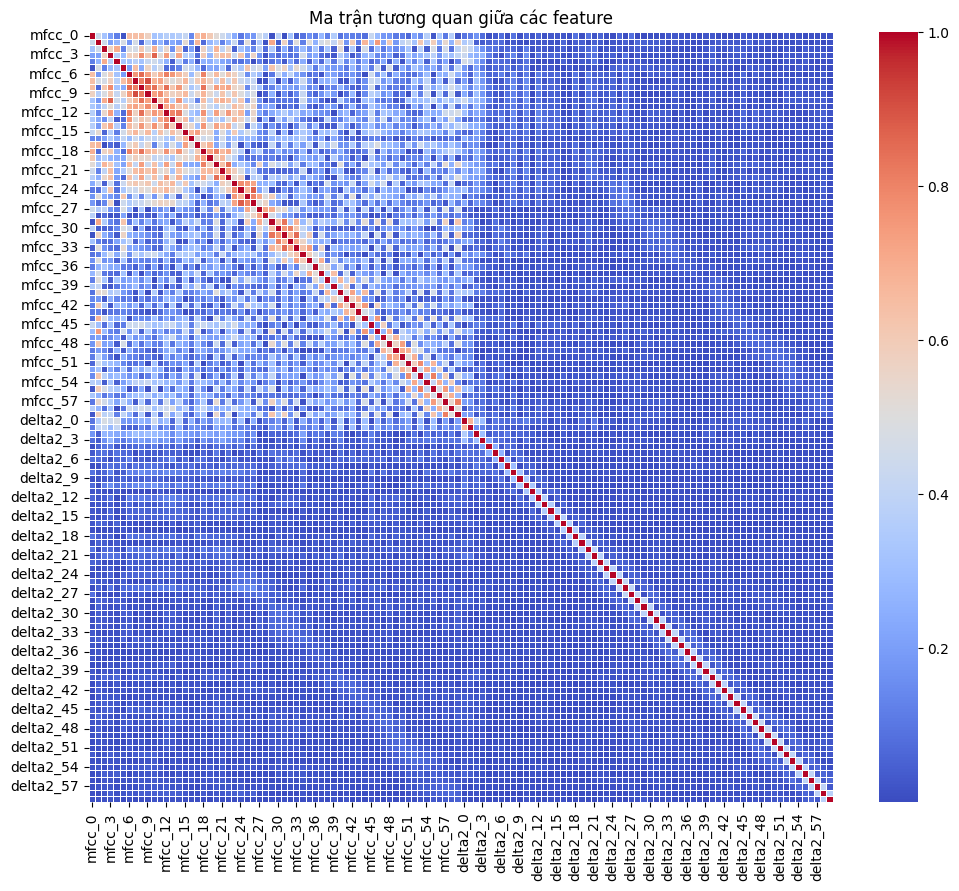


Top 10 feature có tương quan cao nhất:
mfcc_7 - mfcc_9: 0.9122
mfcc_9 - mfcc_7: 0.9122
mfcc_24 - mfcc_26: 0.8780
mfcc_26 - mfcc_24: 0.8780
mfcc_10 - mfcc_3: 0.8688
mfcc_3 - mfcc_10: 0.8688
mfcc_6 - mfcc_8: 0.8557
mfcc_8 - mfcc_6: 0.8557
mfcc_33 - mfcc_31: 0.8517
mfcc_31 - mfcc_33: 0.8517

Threshold tối ưu: 0.92
Số lượng feature còn lại: 120

Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       1.00      0.51      0.67      1800
           1       0.67      1.00      0.80      1800

    accuracy                           0.75      3600
   macro avg       0.83      0.75      0.74      3600
weighted avg       0.83      0.75      0.74      3600


Classification Report (Test Set):
              precision    recall  f1-score   support

           0       1.00      0.34      0.50      2400
           1       0.60      1.00      0.75      2441

    accuracy                           0.67      4841
   macro avg       0.80      0.67  

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import cross_val_score

def plot_correlation_matrix(corr_matrix, top_n=10):
    """Vẽ heatmap của ma trận tương quan và trả về top feature có tương quan cao nhất."""
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title("Ma trận tương quan giữa các feature")
    plt.show()
    
    # Tìm top feature có tương quan cao nhất
    corr_unstack = corr_matrix.unstack().sort_values(ascending=False)
    high_corr_pairs = [(i, j, corr_unstack[i, j]) for i, j in corr_unstack.index if i != j]
    
    print(f"\nTop {top_n} feature có tương quan cao nhất:")
    for pair in high_corr_pairs[:top_n]:
        print(f"{pair[0]} - {pair[1]}: {pair[2]:.4f}")

def find_optimal_threshold(X_train, y_train, thresholds):
    """Tìm threshold tối ưu để loại bỏ các feature có tương quan cao."""
    X_train_df = pd.DataFrame(X_train)
    corr_matrix = X_train_df.corr().abs()
    
    plot_correlation_matrix(corr_matrix)
    
    best_threshold = None
    best_accuracy = 0
    best_features = X_train_df.columns.tolist()
    
    for threshold in thresholds:
        # Xác định các feature có tương quan cao hơn threshold
        high_corr_pairs = [(i, j) for i in corr_matrix.columns for j in corr_matrix.columns
                           if i != j and corr_matrix.loc[i, j] > threshold]
        cols_to_drop = set(j for _, j in high_corr_pairs)
        selected_features = [col for col in X_train_df.columns if col not in cols_to_drop]
        
        # Loại bỏ các cột có tương quan cao
        X_train_filtered = X_train_df[selected_features]
        
        # Huấn luyện SVM với tập train đã lọc
        model = SVC(kernel='linear', random_state=42)
        scores = cross_val_score(model, X_train_filtered, y_train, cv=5, scoring='accuracy')
        mean_accuracy = np.mean(scores)
        
        # Cập nhật threshold tối ưu
        if mean_accuracy > best_accuracy:
            best_accuracy = mean_accuracy
            best_threshold = threshold
            best_features = selected_features
    
    return best_threshold, best_features

def train_and_evaluate(X_train, y_train, X_val, y_val, X_test, y_test, selected_features):
    """Huấn luyện mô hình SVM và đánh giá trên tập Validation & Test."""
    # Áp dụng feature selection
    X_train_final = X_train[selected_features]
    X_val_final = X_val[selected_features]
    X_test_final = X_test[selected_features]
    
    # Huấn luyện SVM
    svm_model = SVC(kernel='linear', random_state=42)
    svm_model.fit(X_train_final, y_train)
    
    # Đánh giá trên tập Validation
    y_val_pred = svm_model.predict(X_val_final)
    print("\nClassification Report (Validation Set):")
    print(classification_report(y_val, y_val_pred))
    
    # Đánh giá trên tập Test
    y_test_pred = svm_model.predict(X_test_final)
    print("\nClassification Report (Test Set):")
    print(classification_report(y_test, y_test_pred))
    
    return selected_features

# Chuyển đổi dữ liệu thành DataFrame để dễ thao tác
X_train_df = pd.DataFrame(X_train)
X_val_df = pd.DataFrame(X_val)
X_test_df = pd.DataFrame(X_test)

# Tìm threshold tối ưu
thresholds = np.arange(0.90, 1.0, 0.01)  # Dễ điều chỉnh ngưỡng
best_threshold, best_features = find_optimal_threshold(X_train_df, y_train, thresholds)

print(f"\nThreshold tối ưu: {best_threshold}")
print(f"Số lượng feature còn lại: {len(best_features)}")

# Huấn luyện mô hình với feature đã chọn
selected_features = train_and_evaluate(X_train_df, y_train, X_val_df, y_val, X_test_df, y_test, best_features)


### Train

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
import os
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

In [6]:
train_df = train_df.drop(columns=['file_name'])
test_df = test_df.drop(columns=['file_name'])
val_df = val_df.drop(columns=['file_name'])

In [7]:
X_train, y_train = train_df.drop(columns=['label']), train_df['label']
X_test, y_test = test_df.drop(columns=['label']), test_df['label']
X_val, y_val = val_df.drop(columns=['label']), val_df['label']

In [8]:
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}, Val shape: {X_val.shape}")

Train shape: (12600, 120), Test shape: (4841, 120), Val shape: (3600, 120)


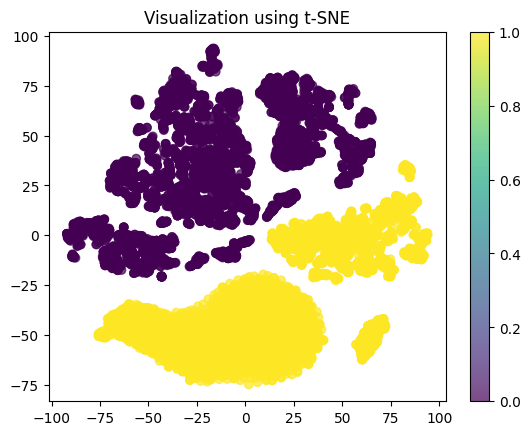

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Giảm chiều dữ liệu xuống 2D bằng t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_train_tsne = tsne.fit_transform(X_train)

plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, cmap='viridis', alpha=0.7)
plt.colorbar()
plt.title("Visualization using t-SNE")
plt.show()


In [9]:
def imbalance_ratio(y):
    counts = pd.Series(y).value_counts()
    return counts.max() / counts.min()

print("Imbalance Ratio in Train Set:", imbalance_ratio(y_train))
print("Imbalance Ratio in Test Set:", imbalance_ratio(y_test))
print("Imbalance Ratio in Validation Set:", imbalance_ratio(y_val))

Imbalance Ratio in Train Set: 1.0
Imbalance Ratio in Test Set: 1.0170833333333333
Imbalance Ratio in Validation Set: 1.0


### KNN

In [ ]:
scaler = StandardScaler()
X_train_Scaled = scaler.fit_transform(X_train)
X_test_Scaled = scaler.transform(X_test)
X_val_Scaled = scaler.transform(X_val)

In [ ]:
param_grid = {
    'n_neighbors': list(range(3, 100, 2)),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

knn = KNeighborsClassifier()

grid_search = GridSearchCV(
    estimator=knn, param_grid=param_grid, 
    cv=5, scoring='accuracy', n_jobs=-1, verbose=1
)

grid_search.fit(X_val_Scaled, y_val)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Accuracy: {best_score:.4f}")

Fitting 5 folds for each of 392 candidates, totalling 1960 fits
Best Parameters: {'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'uniform'}
Best Cross-Validation Accuracy: 0.9994


In [ ]:
best_knn = KNeighborsClassifier(
    n_neighbors=best_params['n_neighbors'], 
    weights=best_params['weights'], 
    algorithm=best_params['algorithm']
)

best_knn.fit(X_train_Scaled, y_train)

y_pred_test = best_knn.predict(X_test_Scaled)
y_pred_val = best_knn.predict(X_val_Scaled)

def evaluate_model(y_true, y_pred):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "f1_score": f1_score(y_true, y_pred),
        "classification_report": classification_report(y_true, y_pred, output_dict=True)
    }

test_results = evaluate_model(y_test, y_pred_test)
val_results = evaluate_model(y_val, y_pred_val)

print("\nTest Set Results:")
print(f"Accuracy: {test_results['accuracy']:.4f}")
print(f"F1 Score: {test_results['f1_score']:.4f}")
print("Classification Report:", test_results["classification_report"])

print("\nValidation Set Results:")
print(f"Accuracy: {val_results['accuracy']:.4f}")
print(f"F1 Score: {val_results['f1_score']:.4f}")
print("Classification Report:", val_results["classification_report"])


Test Set Results:
Accuracy: 0.9630
F1 Score: 0.9644
Classification Report: {'0': {'precision': 0.9937750111160516, 'recall': 0.93125, 'f1-score': 0.9614970961497096, 'support': 2400.0}, '1': {'precision': 0.9363425925925926, 'recall': 0.994264645637034, 'f1-score': 0.9644347307768727, 'support': 2441.0}, 'accuracy': 0.9630241685602148, 'macro avg': {'precision': 0.965058801854322, 'recall': 0.962757322818517, 'f1-score': 0.9629659134632911, 'support': 4841.0}, 'weighted avg': {'precision': 0.9648155949591081, 'recall': 0.9630241685602148, 'f1-score': 0.96297835335378, 'support': 4841.0}}

Validation Set Results:
Accuracy: 0.9742
F1 Score: 0.9748
Classification Report: {'0': {'precision': 0.9994148624926857, 'recall': 0.9488888888888889, 'f1-score': 0.9734967227130237, 'support': 1800.0}, '1': {'precision': 0.9513484928609202, 'recall': 0.9994444444444445, 'f1-score': 0.9748035762665944, 'support': 1800.0}, 'accuracy': 0.9741666666666666, 'macro avg': {'precision': 0.975381677676803, '

### SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

scaler = StandardScaler()
X_Val_Scaled = scaler.fit_transform(X_val)

svm = SVC(kernel='rbf')
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_Val_Scaled, y_val)

best_C = grid_search.best_params_['C']
print(f"Best C found: {best_C}")

Best C found: 1


In [ ]:
svm = SVC(kernel='rbf', C=0.1, shrinking=False)
svm.fit(X_train_Scaled, y_train)

y_pred_test = svm.predict(X_test_Scaled)
y_pred_val = svm.predict(X_val_Scaled)

def evaluate_model(y_true, y_pred, dataset_name):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    report = classification_report(y_true, y_pred)

    print(f"{dataset_name} Performance:")
    print(f"   Accuracy: {accuracy:.4f}")
    print(f"   F1 Score: {f1:.4f}\n")
    print("Classification Report:\n", report)

    return {"accuracy": accuracy, "f1_score": f1, "report": report}

test_results = evaluate_model(y_test, y_pred_test, "Test Set (Scaled MFCC)")
val_results = evaluate_model(y_val, y_pred_val, "Validation Set (Scaled MFCC)")

Test Set (Scaled MFCC) Performance:
   Accuracy: 0.9793
   F1 Score: 0.9799

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98      2400
           1       0.96      1.00      0.98      2441

    accuracy                           0.98      4841
   macro avg       0.98      0.98      0.98      4841
weighted avg       0.98      0.98      0.98      4841

Validation Set (Scaled MFCC) Performance:
   Accuracy: 0.9631
   F1 Score: 0.9643

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.93      0.96      1800
           1       0.93      1.00      0.96      1800

    accuracy                           0.96      3600
   macro avg       0.97      0.96      0.96      3600
weighted avg       0.97      0.96      0.96      3600



### NB

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score

nb_raw = GaussianNB()

nb_raw.fit(X_train, y_train)

y_test_pred_raw = nb_raw.predict(X_test)
y_val_pred_raw = nb_raw.predict(X_val)

def evaluate_model(y_true, y_pred, model_type):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"\n{model_type} Model Performance:")
    print(f"   Accuracy: {accuracy:.4f}")
    print(f"   F1 Score: {f1:.4f}")
    return accuracy, f1

print("\nEvaluating Naïve Bayes on Raw MFCC Features:")
test_results_raw = evaluate_model(y_test, y_test_pred_raw, "NB Raw (Test)")
val_results_raw = evaluate_model(y_val, y_val_pred_raw, "NB Raw (Validation)")



Evaluating Naïve Bayes on Raw MFCC Features:

NB Raw (Test) Model Performance:
   Accuracy: 0.9213
   F1 Score: 0.9267

NB Raw (Validation) Model Performance:
   Accuracy: 0.9603
   F1 Score: 0.9610


### RF

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd

feature selection

In [12]:
rf_initial = RandomForestClassifier(n_estimators=100, random_state=42)
rf_initial.fit(X_train, y_train)

# Lấy độ quan trọng của từng feature
feature_importances = rf_initial.feature_importances_

# Chọn các feature có importance
threshold = np.mean(feature_importances)
important_features = np.where(feature_importances > threshold)[0]

# Lọc tập dữ liệu theo các feature quan trọng
X_train_selected = X_train.iloc[:, important_features]
X_test_selected = X_test.iloc[:, important_features]
X_val_selected = X_val.iloc[:, important_features]

In [13]:
param_grid = {'n_estimators': list(range(25, 201, 5))}
rf = RandomForestClassifier()
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_selected, y_train)

best_params = grid_search.best_params_
print("Best n_estimators:", best_params['n_estimators'])


Best n_estimators: 35


In [14]:
# Hiển thị số feature trước và sau khi giảm chiều
num_features_before = X_train.shape[1]
num_features_after = X_train_selected.shape[1]

print(f"\nSố lượng feature trước khi giảm chiều: {num_features_before}")
print(f"Số lượng feature sau khi giảm chiều: {num_features_after}")



Số lượng feature trước khi giảm chiều: 120
Số lượng feature sau khi giảm chiều: 23


In [15]:
rf_selected = RandomForestClassifier(n_estimators=best_params['n_estimators'], random_state=42)
rf_selected.fit(X_train_selected, y_train)

# Dự đoán trên tập test và validation
y_test_pred_selected = rf_selected.predict(X_test_selected)
y_val_pred_selected = rf_selected.predict(X_val_selected)

# Hàm đánh giá mô hình
def evaluate_model(y_true, y_pred, model_type):
    precision = precision_score(y_true, y_pred, average="binary")
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"\n{model_type} Model Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Classification Report:\n{classification_report(y_true, y_pred)}")
    return precision, accuracy, f1

print("\nEvaluating Model after Feature Selection:")
selected_test_results = evaluate_model(y_test, y_test_pred_selected, "rf Selected (Test)")
selected_val_results = evaluate_model(y_val, y_val_pred_selected, "rf Selected (Validation)")



Evaluating Model after Feature Selection:

rf Selected (Test) Model Performance:
Accuracy: 0.9969
F1 Score: 0.9969
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2400
           1       0.99      1.00      1.00      2441

    accuracy                           1.00      4841
   macro avg       1.00      1.00      1.00      4841
weighted avg       1.00      1.00      1.00      4841


rf Selected (Validation) Model Performance:
Accuracy: 0.9303
F1 Score: 0.9258
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93      1800
           1       0.99      0.87      0.93      1800

    accuracy                           0.93      3600
   macro avg       0.94      0.93      0.93      3600
weighted avg       0.94      0.93      0.93      3600



feature selection + PCA

In [16]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import numpy as np

# Huấn luyện mô hình RandomForest để lấy feature importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Lấy độ quan trọng của từng feature
feature_importances = rf.feature_importances_

# Xác định ngưỡng trung bình
threshold = np.mean(feature_importances)

# Tách feature quan trọng và ít quan trọng
important_features_idx = np.where(feature_importances >= threshold)[0]
less_important_features_idx = np.where(feature_importances < threshold)[0]

X_train_selected = X_train.iloc[:, important_features_idx]
X_test_selected = X_test.iloc[:, important_features_idx]
X_val_selected = X_val.iloc[:, important_features_idx]

# Xác định số lượng feature từng bước
print(f"Tổng số feature ban đầu: {X_train.shape[1]}")
print(f"feature selection: {X_train_selected.shape[1]}")
print(f"PCA: {len(less_important_features_idx)}")

# Chuẩn hóa dữ liệu trước khi áp dụng PCA
scaler = StandardScaler()
X_train_pca_input = scaler.fit_transform(X_train.iloc[:, less_important_features_idx])
X_test_pca_input = scaler.transform(X_test.iloc[:, less_important_features_idx])
X_val_pca_input = scaler.transform(X_val.iloc[:, less_important_features_idx])

# Áp dụng PCA lên phần feature ít quan trọng
n_pca_components = min(5, len(less_important_features_idx))
if n_pca_components > 0:
    pca = PCA(n_components=n_pca_components)
    X_train_pca = pca.fit_transform(X_train_pca_input)
    X_test_pca = pca.transform(X_test_pca_input)
    X_val_pca = pca.transform(X_val_pca_input)
    print(f"PCA component: {n_pca_components}")
else:
    X_train_pca = np.empty((X_train.shape[0], 0))
    X_test_pca = np.empty((X_test.shape[0], 0))
    X_val_pca = np.empty((X_val.shape[0], 0))
    print("Không có feature nào được PCA giữ lại!")

# Ghép dữ liệu lại
X_train_final = np.hstack((X_train_selected, X_train_pca))
X_test_final = np.hstack((X_test_selected, X_test_pca))
X_val_final = np.hstack((X_val_selected, X_val_pca))

print(f"sau Feature Selection + PCA: {X_train_final.shape[1]}")

param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_val_final, y_val)

best_params = grid_search.best_params_
print("\nBest Parameters:", best_params)

# Huấn luyện lại mô hình với tham số tối ưu
rf_final = RandomForestClassifier(**best_params, random_state=42)
rf_final.fit(X_train_final, y_train)

# Dự đoán và đánh giá
y_test_pred = rf_final.predict(X_test_final)
y_val_pred = rf_final.predict(X_val_final)

evaluate_model(y_test, y_test_pred, "rf Hybrid (Test)")
evaluate_model(y_val, y_val_pred, "rf Hybrid (Validation)")


Tổng số feature ban đầu: 120
feature selection: 23
PCA: 97
PCA component: 5
sau Feature Selection + PCA: 28

Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}

rf Hybrid (Test) Model Performance:
Accuracy: 0.9936
F1 Score: 0.9936
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2400
           1       1.00      0.99      0.99      2441

    accuracy                           0.99      4841
   macro avg       0.99      0.99      0.99      4841
weighted avg       0.99      0.99      0.99      4841


rf Hybrid (Validation) Model Performance:
Accuracy: 0.9642
F1 Score: 0.9630
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1800
           1       1.00      0.93      0.96      1800

    accuracy                           0.96      3600
   macro avg       0.97      0.96      0.96      3600
weighted avg     

(0.995257854179016, 0.9641666666666666, 0.9630054488098652)

### ensemble learning

#### Soft Voting

In [40]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB


best_models = [
    ("NB", GaussianNB()),
    ("Random Forest", RandomForestClassifier(
        n_estimators=35, criterion="gini", max_depth=None, min_samples_split=2, random_state=42
    ))
]

soft_voting_clf = VotingClassifier(estimators=best_models, voting='soft', n_jobs=-1)
soft_voting_clf.fit(X_train_final, y_train)

# Dự đoán
y_val_pred = soft_voting_clf.predict(X_val_final)
y_test_pred = soft_voting_clf.predict(X_test_final)

# Đánh giá
val_acc = accuracy_score(y_val, y_val_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print("\nĐánh giá Soft Voting trên tập validation:")
print(classification_report(y_val, y_val_pred))

print("\nĐánh giá Soft Voting trên tập test:")
print(classification_report(y_test, y_test_pred))

print(f"Accuracy trên tập validation: {val_acc:.4f}")
print(f"Accuracy trên tập test: {test_acc:.4f}")


Đánh giá Soft Voting trên tập validation:
              precision    recall  f1-score   support

           0       1.00      0.81      0.89      1800
           1       0.84      1.00      0.91      1800

    accuracy                           0.90      3600
   macro avg       0.92      0.90      0.90      3600
weighted avg       0.92      0.90      0.90      3600


Đánh giá Soft Voting trên tập test:
              precision    recall  f1-score   support

           0       1.00      0.85      0.92      2400
           1       0.87      1.00      0.93      2441

    accuracy                           0.92      4841
   macro avg       0.93      0.92      0.92      4841
weighted avg       0.93      0.92      0.92      4841

Accuracy trên tập validation: 0.9044
Accuracy trên tập test: 0.9234


#### Hard Voting

In [48]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier

best_models = [
    ("NB", GaussianNB()),
    ("Random Forest", RandomForestClassifier(
        n_estimators=35, criterion="entropy", max_depth=None, min_samples_split=2, random_state=42
    )),
    ("Extra Trees", ExtraTreesClassifier(
        criterion="entropy", max_depth=None, min_samples_split=2, n_estimators=200, random_state=42
    ))
]

soft_voting_clf = VotingClassifier(estimators=best_models, voting='hard', n_jobs=-1)
soft_voting_clf.fit(X_train_final, y_train)

# Dự đoán
y_val_pred = soft_voting_clf.predict(X_val_final)
y_test_pred = soft_voting_clf.predict(X_test_final)

# Đánh giá
val_acc = accuracy_score(y_val, y_val_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print("\nĐánh giá Soft Voting trên tập validation:")
print(classification_report(y_val, y_val_pred))

print("\nĐánh giá Soft Voting trên tập test:")
print(classification_report(y_test, y_test_pred))

print(f"Accuracy trên tập validation: {val_acc:.4f}")
print(f"Accuracy trên tập test: {test_acc:.4f}")


Đánh giá Soft Voting trên tập validation:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      1800
           1       0.98      0.90      0.93      1800

    accuracy                           0.94      3600
   macro avg       0.94      0.94      0.94      3600
weighted avg       0.94      0.94      0.94      3600


Đánh giá Soft Voting trên tập test:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2400
           1       1.00      1.00      1.00      2441

    accuracy                           1.00      4841
   macro avg       1.00      1.00      1.00      4841
weighted avg       1.00      1.00      1.00      4841

Accuracy trên tập validation: 0.9375
Accuracy trên tập test: 0.9988


#### Weighted Voting

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier

best_models = [
    ("NB", GaussianNB()),
    ("Random Forest", RandomForestClassifier(
        n_estimators=35, criterion="entropy", max_depth=None, min_samples_split=2, random_state=42
    ))
]


weights = []
for name, model in best_models:
    model.fit(X_train_final, y_train)
    y_val_pred = model.predict(X_val_final)
    acc = accuracy_score(y_val, y_val_pred)
    weights.append(acc)
    
print("Weights theo accuracy trên validation:", weights)

soft_voting_clf = VotingClassifier(estimators=best_models, voting='soft', weights=weights, n_jobs=-1)

soft_voting_clf.fit(X_train_final, y_train)

y_val_pred = soft_voting_clf.predict(X_val_final)
y_test_pred = soft_voting_clf.predict(X_test_final)

val_acc = accuracy_score(y_val, y_val_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Accuracy on validation: {val_acc:.4f}")
print(classification_report(y_val, y_val_pred))

print(f"Accuracy on test: {test_acc:.4f}")
print(classification_report(y_test, y_test_pred))

Weights theo accuracy trên validation: [0.8897222222222222, 0.9305555555555556]
Accuracy on validation: 0.9039
              precision    recall  f1-score   support

           0       1.00      0.81      0.89      1800
           1       0.84      1.00      0.91      1800

    accuracy                           0.90      3600
   macro avg       0.92      0.90      0.90      3600
weighted avg       0.92      0.90      0.90      3600

Accuracy on test: 0.9234
              precision    recall  f1-score   support

           0       1.00      0.85      0.92      2400
           1       0.87      1.00      0.93      2441

    accuracy                           0.92      4841
   macro avg       0.93      0.92      0.92      4841
weighted avg       0.93      0.92      0.92      4841



#### Stacking

In [47]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Tạo các mô hình base
best_models = [
    ("NB", GaussianNB()),
    ("Random Forest", RandomForestClassifier(
        n_estimators=35, criterion="entropy", max_depth=None, min_samples_split=2, random_state=42
    ))
]

# Meta model - dùng Logistic Regression (thay vì Linear Regression vì bài toán phân loại)
meta_model = LogisticRegression(random_state=42)

# Tạo Stacking Classifier
stacking_clf = StackingClassifier(estimators=best_models, final_estimator=meta_model, cv=5, n_jobs=-1)

# Huấn luyện mô hình
stacking_clf.fit(X_train_final, y_train)

# Dự đoán
y_val_pred = stacking_clf.predict(X_val_final)
y_test_pred = stacking_clf.predict(X_test_final)

# Đánh giá mô hình
val_acc = accuracy_score(y_val, y_val_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print("\nĐánh giá Stacking trên tập validation:")
print(classification_report(y_val, y_val_pred))
print(f"Accuracy trên tập validation: {val_acc:.4f}")

print("\nĐánh giá Stacking trên tập test:")
print(classification_report(y_test, y_test_pred))
print(f"Accuracy trên tập test: {test_acc:.4f}")



Đánh giá Stacking trên tập validation:
              precision    recall  f1-score   support

           0       1.00      0.80      0.89      1800
           1       0.83      1.00      0.91      1800

    accuracy                           0.90      3600
   macro avg       0.92      0.90      0.90      3600
weighted avg       0.92      0.90      0.90      3600

Accuracy trên tập validation: 0.9008

Đánh giá Stacking trên tập test:
              precision    recall  f1-score   support

           0       1.00      0.85      0.92      2400
           1       0.87      1.00      0.93      2441

    accuracy                           0.92      4841
   macro avg       0.93      0.92      0.92      4841
weighted avg       0.93      0.92      0.92      4841

Accuracy trên tập test: 0.9234


In [31]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report

# Định nghĩa tập tham số cần tìm kiếm
param_grid = {
    'criterion' :['gini', 'entropy', 'log_loss'],
    'n_estimators': [30, 40, 50, 60, 100, 150, 200],
    'max_depth': [ 10, 20, 30],
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10]
}

# Khởi tạo mô hình Random Forest
rf_model = ExtraTreesClassifier(random_state=42)

# Khởi tạo GridSearchCV với 5-fold cross-validation
grid_search = GridSearchCV(
    rf_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1
)

# Chạy Grid Search trên tập huấn luyện
grid_search.fit(X_train_final, y_train)

# Lấy tham số tốt nhất
best_params = grid_search.best_params_
print(f"🔍 Best parameters: {best_params}")

# Huấn luyện mô hình với tham số tối ưu
best_model = ExtraTreesClassifier(**best_params, random_state=42)
best_model.fit(X_train_final, y_train)

# Dự đoán trên tập validation và test
y_val_pred = best_model.predict(X_val_final)
y_test_pred = best_model.predict(X_test_final)

# Đánh giá mô hình trên tập validation
print("\n📊 Đánh giá trên tập validation:")
print(classification_report(y_val, y_val_pred))

# Đánh giá mô hình trên tập test
print("\n📊 Đánh giá trên tập test:")
print(classification_report(y_test, y_test_pred))

# In accuracy trên validation và test
val_accuracy = accuracy_score(y_val, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"\n✅ Accuracy trên tập validation: {val_accuracy:.4f}")
print(f"✅ Accuracy trên tập test: {test_accuracy:.4f}")

Fitting 5 folds for each of 567 candidates, totalling 2835 fits


C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


🔍 Best parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 3, 'n_estimators': 200}

📊 Đánh giá trên tập validation:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94      1800
           1       0.99      0.88      0.94      1800

    accuracy                           0.94      3600
   macro avg       0.94      0.94      0.94      3600
weighted avg       0.94      0.94      0.94      3600


📊 Đánh giá trên tập test:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2400
           1       1.00      1.00      1.00      2441

    accuracy                           1.00      4841
   macro avg       1.00      1.00      1.00      4841
weighted avg       1.00      1.00      1.00      4841


✅ Accuracy trên tập validation: 0.9389
✅ Accuracy trên tập test: 0.9957
